In [107]:
import random

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_sparse
import torch.sparse

from torch_scatter import scatter
from tqdm.auto import tqdm

In [108]:
torch.autograd.set_detect_anomaly(True)

In [109]:
from torch_geometric.datasets import Planetoid
data = Planetoid(root='data/Planetoid', name="Cora")[0]

n_nodes = data.num_nodes
n_edges = data.num_edges
n_features = data.num_features
n_targets = len(np.unique(data.y))

In [110]:
dict_vertices = {}

# Bind each vertex to a list of connected vertices
for v1, v2 in zip(*data.edge_index[:, :]):
    if str(v1.item()) not in dict_vertices:
        dict_vertices[str(v1.item())] = []
    dict_vertices[str(v1.item())] += [str(v2.item())]

In [111]:
adj_data = np.zeros((n_nodes, n_nodes))

for key, values in dict_vertices.items():
    for value in values:
        adj_data[int(key)][int(value)] = 1

adj_mat = scipy.sparse.coo_matrix(adj_data, dtype=np.float32)
deg_mat = scipy.sparse.diags(np.asarray(adj_mat.sum(axis=0))[0], shape=(n_nodes, n_nodes), dtype=np.float32)

adj_mat_tilde = adj_mat + 2*scipy.sparse.identity(n_nodes)
deg_mat_tilde = deg_mat + 2*scipy.sparse.identity(n_nodes)
norm_adj_mat = deg_mat_tilde.power(-0.5) @ adj_mat_tilde @ deg_mat_tilde.power(-0.5)
# Convert from DIA fromat to COO format
norm_adj_mat = norm_adj_mat.tocoo()

indices = np.vstack((norm_adj_mat.row, norm_adj_mat.col))
values = norm_adj_mat.data
norm_adj_mat = torch.sparse_coo_tensor(indices, values, dtype=torch.float)


In [112]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
data = data.to(device)
norm_adj_mat = norm_adj_mat.to(device)
print(scipy.sparse.issparse(norm_adj_mat))

cpu
False


In [113]:
class GCNLayer(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(GCNLayer, self).__init__()
        self.w = nn.Linear(n_inputs, n_outputs)
        nn.init.kaiming_uniform_(self.w.weight)*0.01
        self.drop = nn.Dropout(p=0)
        
    def forward(self, x, norm_adj_mat):
        x = self.drop(x)
        x = torch.spmm(norm_adj_mat, x) 
        x = self.w(x)
        x = F.elu(x)
        
        return x
    
gcn_layer = GCNLayer(n_features, 5)
gcn_layer.to(device)

GCNLayer(
  (w): Linear(in_features=1433, out_features=5, bias=True)
  (drop): Dropout(p=0, inplace=False)
)

In [114]:
def ts_index_select(A,sdim,idx):
  Ats = torch_sparse.SparseTensor.from_torch_sparse_coo_tensor(A)
  Ats_select = torch_sparse.index_select(Ats,sdim,idx)
  row, col, value = Ats_select.coo()
  As_select = torch.sparse_coo_tensor(torch.stack([row, col], dim=0), value, (Ats_select.size(0), Ats_select.size(1)))
  return As_select

In [115]:
def top_k_graph(scores, g, h, k):
    num_nodes = g.shape[0]
    values, idx = torch.topk(scores, max(2, k))
    new_h = h[idx, :]
    values = torch.unsqueeze(values, -1)
    new_h = torch.mul(new_h, values)
    un_g = g.bool().float()
    un_g = torch.matmul(un_g, un_g).bool().float()
    un_g = ts_index_select(un_g, 0, idx)
    un_g = ts_index_select(un_g, 1, idx)
    g = norm_g(un_g)
    return g, new_h, idx

def norm_g(g):
    
    g = g.to_dense()
    g = scipy.sparse.coo_matrix(g, dtype=np.float32)
    g = g.tocoo()
    indices = np.vstack((g.row, g.col))
    values = g.data
    g = torch.sparse_coo_tensor(indices, values, dtype=torch.float)


    return g

In [116]:
class Pool(nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = nn.Sigmoid()
        self.proj = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity()

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)

In [117]:
class Unpool(nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, adj, x, pre_x, idx):
        new_x = x.new_zeros([adj.shape[0], x.shape[1]])
        new_x[idx] = x
        return adj, new_x

In [118]:
class last_GCN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super(last_GCN, self).__init__()
        self.hidden = GCNLayer(n_inputs, n_hidden)
        self.output = GCNLayer(n_hidden, n_outputs)
        
    def forward(self, x, norm_adj_mat):
        x = self.hidden(x, norm_adj_mat)
        x = self.output(x, norm_adj_mat)
        return x


In [119]:
class bottom_GCN(nn.Module):
    def __init__(self, n_inputs, n_hidden):
        super(bottom_GCN, self).__init__()
        self.hidden = GCNLayer(n_inputs, n_inputs)
        
    def forward(self, x, norm_adj_mat):
        x = self.hidden(x, norm_adj_mat)
        x = F.sigmoid(x)
        return x

In [120]:
#ks vector with number of nodes
#act should be nn.Identity
#drop_p is dropout rate 0.8


class GUNet(nn.Module):
    def __init__(self, ks, dim, act, drop_p):
        super(GUNet, self).__init__()
        self.ks = ks
        self.bottom_gcn = GCNLayer(dim,dim)
        self.down_gcns = nn.ModuleList()
        self.up_gcns = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.l_n = len(ks)
        for i in range(self.l_n):
            self.down_gcns.append(GCNLayer(dim, dim))
            self.up_gcns.append(GCNLayer(dim, dim))
            self.pools.append(Pool(ks[i], dim, 0.2))
            self.unpools.append(Unpool(dim, dim, drop_p))


    def forward(self, adj, x):
        adj_ms = []
        indices_list = []
        down_outs = []
        xs = []
        org_x = x
        for i in range(self.l_n):

            x = self.down_gcns[i](x, adj)
            adj_ms.append(adj)
            down_outs.append(x)
            adj, x, idx = self.pools[i](adj, x)
            indices_list.append(idx)
        x = self.bottom_gcn(x, adj)

        for i in range(self.l_n):

            up_idx = self.l_n - i - 1
            adj, idx = adj_ms[up_idx], indices_list[up_idx]
            adj, x = self.unpools[i](adj, x, down_outs[up_idx], idx)
            x = self.up_gcns[i](x, adj)
            x = x.add(down_outs[up_idx]) #addition or concatenation???
            sum_x = torch.sum(x, 0)
            x = x / sum_x
            xs.append(x)
        x = x.add(org_x)

        
        xs.append(x)
        return xs

ks = [2000, 1000, 500, 200]
#ks = [5000, 2000, 1000, 500]
dim =  data.num_features

In [121]:
class Net(nn.Module):
    def __init__(self, ks, n_inputs, n_hidden, n_outputs):
        super(Net, self).__init__()
        self.ks = ks
        self.first_gcn = GCNLayer(n_inputs, n_hidden)
        self.gunet = GUNet(self.ks, n_hidden, nn.Identity(), 0.3)
        self.output = last_GCN(n_hidden, 32, n_targets)
        
    def forward(self, x, norm_adj_mat):
        x = self.first_gcn(x, norm_adj_mat)
        x = self.gunet(norm_adj_mat, x)
        x = self.output(x[-1], norm_adj_mat)
        x = F.softmax(x, dim=1)
        
        return x

net = Net(ks, data.num_features, 512, n_targets)
net.to(device)

Net(
  (first_gcn): GCNLayer(
    (w): Linear(in_features=1433, out_features=512, bias=True)
    (drop): Dropout(p=0, inplace=False)
  )
  (gunet): GUNet(
    (bottom_gcn): GCNLayer(
      (w): Linear(in_features=512, out_features=512, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (down_gcns): ModuleList(
      (0): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)
        (drop): Dropout(p=0, inplace=False)
      )
      (1): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)
        (drop): Dropout(p=0, inplace=False)
      )
      (2): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)
        (drop): Dropout(p=0, inplace=False)
      )
      (3): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)
        (drop): Dropout(p=0, inplace=False)
      )
    )
    (up_gcns): ModuleList(
      (0): GCNLayer(
        (w): Linear(in_features=512, out_features=512, bias=True)


In [122]:
epochs = 100
criterion = nn.CrossEntropyLoss()
loss_func = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [128]:
training_loss = []
validation_accuracy = []

for _ in tqdm(range(epochs), leave=False):
    # Get the inputs; data is a list of [inputs, labels]
    inputs, labels = data.x, data.y[data.train_mask]

    # Zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)

    # Forward + backward + optimize
    outputs = net(inputs, norm_adj_mat)[data.train_mask]
    if _ == 1:
        print(outputs[-10:-1],labels[-10:-1])
    if _ == epochs-1:
        print(outputs[-10:-1],labels[-10:-1])
    #print(type(outputs), labels.shape)
    with torch.cuda.amp.autocast():
        loss = criterion(outputs, labels)
        #loss = loss_func(outputs, labels)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    training_loss += [loss.item()]
    
    inputs, labels = data.x, data.y[data.val_mask]    
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        # Calculate outputs by running embeddings through the network
        outputs = net(inputs, norm_adj_mat)[data.val_mask]
    
    # The class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()

    accuracy = correct / total

    #if _ % 10 == 0:
    #    print('Loss: ', loss.item(), '\t Accuracy: ', accuracy)
    validation_accuracy += [accuracy]

  1%|          | 1/100 [00:05<09:05,  5.51s/it]

tensor([[2.7691e-01, 1.1540e-01, 3.1942e-02, 8.6545e-02, 5.0589e-02, 1.8808e-01,
         2.5053e-01],
        [2.0099e-02, 6.8833e-01, 9.9988e-02, 1.2808e-01, 1.3866e-02, 3.3897e-02,
         1.5743e-02],
        [1.8093e-03, 5.4914e-03, 9.6662e-04, 1.3260e-02, 1.1763e-03, 9.7549e-01,
         1.8078e-03],
        [1.7653e-02, 9.1792e-01, 5.3749e-03, 9.7873e-03, 8.3226e-03, 1.9518e-02,
         2.1428e-02],
        [7.0198e-03, 9.3841e-01, 5.7747e-03, 4.0151e-03, 5.2668e-03, 1.1236e-02,
         2.8275e-02],
        [5.2618e-03, 9.8209e-01, 1.3010e-03, 1.3488e-03, 3.1830e-03, 2.3606e-03,
         4.4593e-03],
        [2.1659e-02, 9.0028e-01, 9.1746e-03, 1.0103e-02, 7.7939e-03, 3.2963e-02,
         1.8022e-02],
        [3.7405e-03, 9.8823e-01, 7.4702e-04, 8.2528e-04, 2.2840e-03, 1.3820e-03,
         2.7958e-03],
        [4.2138e-02, 7.0554e-01, 2.4724e-02, 5.7728e-02, 2.0749e-02, 7.7640e-02,
         7.1482e-02]], grad_fn=<SliceBackward0>) tensor([5, 1, 5, 1, 1, 1, 1, 1, 1])


 99%|█████████▉| 99/100 [12:12<00:07,  7.60s/it]

tensor([[2.3355e-02, 1.1147e-02, 4.8117e-03, 8.0861e-03, 4.1137e-03, 9.2959e-01,
         1.8898e-02],
        [1.3548e-03, 9.4766e-01, 3.0849e-02, 1.5011e-02, 9.7736e-04, 3.3850e-03,
         7.6384e-04],
        [6.1439e-05, 2.2025e-04, 3.9048e-05, 7.7959e-04, 2.7547e-05, 9.9883e-01,
         4.2934e-05],
        [3.7340e-03, 9.8234e-01, 2.0904e-03, 1.0632e-03, 1.2328e-03, 7.0532e-03,
         2.4893e-03],
        [9.2996e-04, 9.8684e-01, 2.7620e-03, 5.3202e-04, 5.7411e-04, 4.8906e-03,
         3.4692e-03],
        [7.1263e-04, 9.9783e-01, 1.4094e-04, 8.8802e-05, 3.1209e-04, 6.5955e-04,
         2.5224e-04],
        [5.3238e-03, 9.8565e-01, 2.1436e-03, 8.1605e-04, 6.2105e-04, 4.0287e-03,
         1.4167e-03],
        [4.3100e-04, 9.9879e-01, 6.2457e-05, 4.4137e-05, 1.9861e-04, 3.4659e-04,
         1.2458e-04],
        [1.7632e-02, 8.9553e-01, 1.5706e-02, 1.7260e-02, 5.0209e-03, 2.7625e-02,
         2.1228e-02]], grad_fn=<SliceBackward0>) tensor([5, 1, 5, 1, 1, 1, 1, 1, 1])


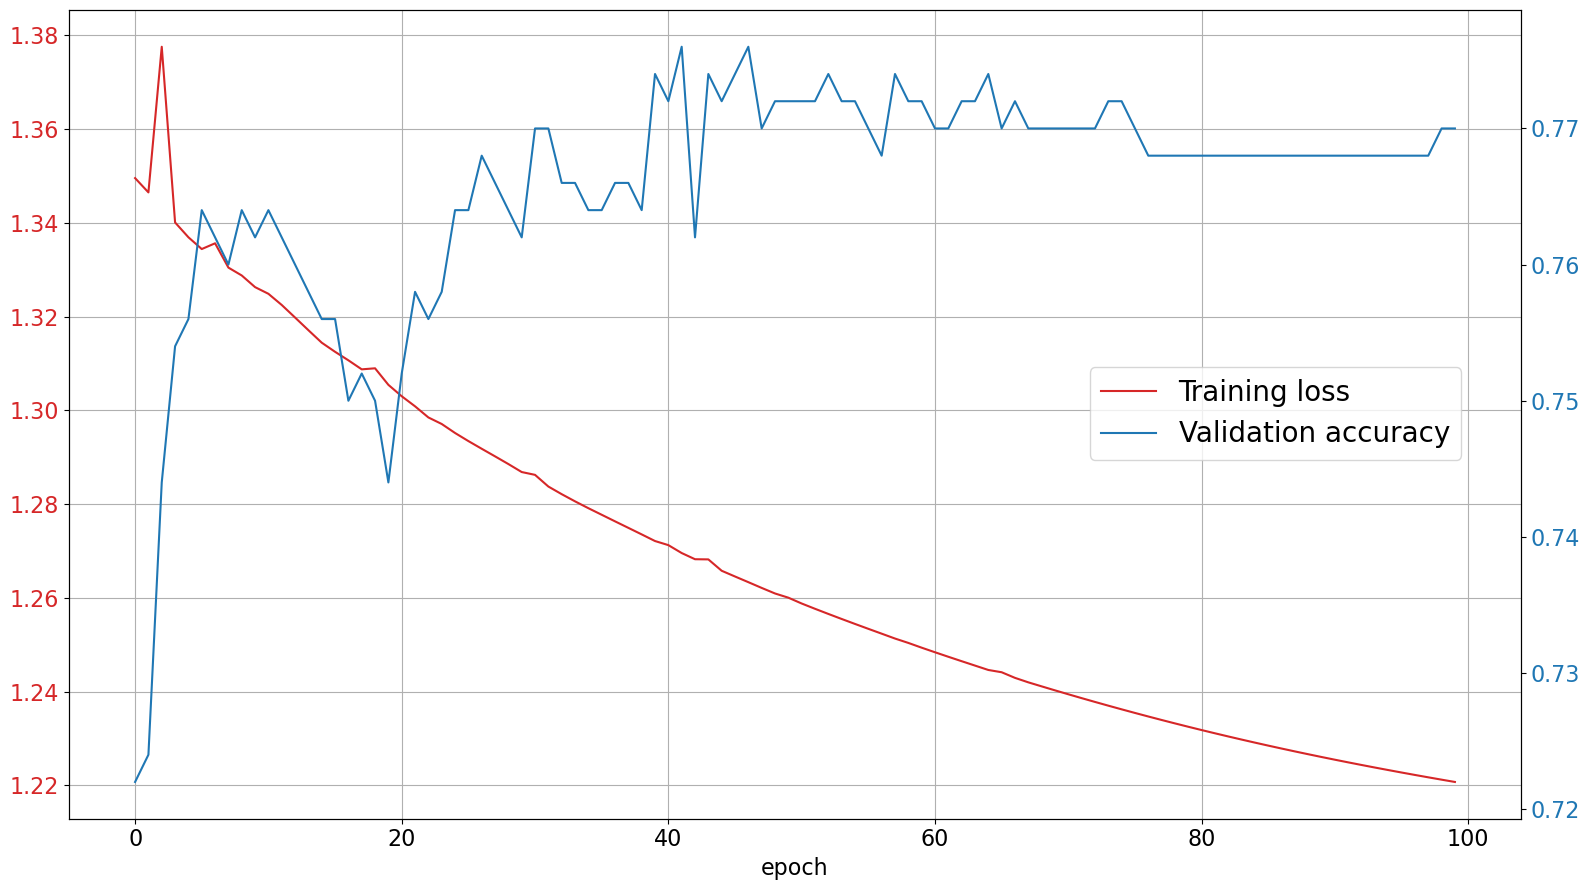

In [129]:
fig, ax = plt.subplots(figsize=(16, 9))

color = 'tab:red'
ax.plot(np.arange(epochs), training_loss, color=color, label='Training loss')
ax.tick_params(axis='y', labelcolor=color, labelsize=16)

color = 'tab:blue'
right_y = ax.twinx()
right_y.plot(np.arange(epochs), validation_accuracy, color=color, label='Validation accuracy')
right_y.tick_params(axis='y', labelcolor=color, labelsize=16)

ax.set_xlabel('epoch', fontsize=16)
ax.tick_params(axis='x', labelsize=16)

fig.tight_layout()
ax.grid(True)
fig.legend(loc='center right', fontsize=20, bbox_to_anchor=(0.925, 0.535))
plt.show()

In [130]:
inputs, labels = data.x, data.y[data.test_mask]

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    # Calculate outputs by running embeddings through the network
    outputs = net(inputs, norm_adj_mat)[data.test_mask]

# The class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs.data, 1)
total = labels.size(0)
correct = (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy in the test set: {100 * accuracy:.2f}%')

Accuracy in the test set: 79.80%


In [126]:
from torchmetrics import AUROC

In [131]:
auc = AUROC(task="multiclass", num_classes=7)
roc = auc(outputs.data,labels.data)
print(roc)

tensor(0.9654)
